# Ridge Regression

In [52]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector

In [53]:
tech_list = ['SMA','EMA','STOCH_k','STOCK_d','RSI','MFI','SAR','AD','MACD','MACD_Signal','MACD_Histo','VWAP','SPY','NDAQ']
funda_list = ['pcf','PEG_trailing','dpr','npm','gpm','roa','roe','capital_ratio','de_ratio','cash_ratio','curr_ratio','inv_turn','pay_turn','sale_nwc','rd_sale','accrual']
macro_list = ['gdpr1','gdpr2','cpi','bond20yr','bond30yr','fedfunds','cpir','wpir','unemp','employ']
nlp_list = ['Pos_lag2','Pos_lag3','Neg_lag1','Neg_lag2','Neg_lag3','Neu_lag1','Neu_lag2','Neu_lag3']
stock_list = ['AAPL','AMZN','BRK-B','GOOG','JNJ','META','MSFT','NVDA','TSLA','V']

## Ridge Penalty

In [16]:
stock_score = dict()
for j in stock_list:
    freq = 'Daily'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    alpha_score = []
    for i in np.linspace(500,40000,1000):
        cv = 5
        scores = []
        tscv = TimeSeriesSplit(n_splits=cv)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            pipe = make_pipeline(MinMaxScaler(),Ridge(alpha=i))
            pipe.fit(X_train,y_train)
            y_pred = pipe.predict(X_test)
            scores.append(mean_squared_error(y_pred,y_test,squared=False))
        average_score = np.mean(scores)
        alpha_score.append(average_score)
    print(j,alpha_score)
    stock_score[j] = alpha_score

AAPL [277.62449514715865, 262.77283979166975, 249.63704130148867, 238.10593727871145, 228.37654028945062, 220.3787008108382, 213.39292769579166, 207.02269737823667, 201.12137181177962, 195.61486729401946, 190.45440821316396, 185.6034362845498, 181.0331617986256, 176.72107094398424, 172.65118105460638, 168.81620194766842, 165.22077750163234, 161.87528258560752, 158.76582999148837, 155.84587596758448, 153.07127057517351, 150.4149013176153, 147.86101357586668, 145.39951509054563, 143.02314064907574, 140.72616399290982, 138.50378921532, 136.35184133693042, 134.26659584105914, 132.24467707229712, 130.28299305038928, 128.3786907740704, 126.52912375025085, 124.73182723049744, 122.98449856232074, 121.2849810987016, 119.63125069054755, 118.02140412587664, 116.45364908470438, 114.9262953070775, 113.43774675480162, 111.98649460284682, 110.57111093450503, 109.19024304127598, 107.8426082479718, 106.52698919802677, 105.24222954501747, 103.98723000495093, 102.76094473063358, 101.56237797486821, 100.3

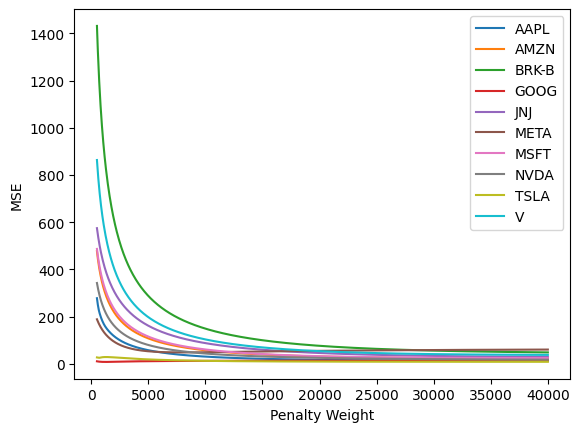

In [19]:
for j in stock_list:
    plt.plot(np.linspace(500,40000,1000),stock_score[j],label = j)
plt.xlabel('Penalty Weight')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Since the penalty is too high, we think there must be a lot of unuseful features within the dataset. Therefore, we want to use feature selection to tune a better result

In [55]:
stock_score = dict()
for j in stock_list:
    freq = 'Daily'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    alpha_score = []

    for i in range(5,49,4):
        cv = 5
        scores = []
        tscv = TimeSeriesSplit(n_splits=cv)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            pipe = make_pipeline(MinMaxScaler(),Ridge(alpha=i))
            sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=i,scoring='neg_root_mean_squared_error')
            sfs.fit(X_train,y_train)
            X_train = sfs.transform(X_train)
            pipe.fit(X_train,y_train)
            X_test =  sfs.transform(X_test)
            y_pred = pipe.predict(X_test)
            scores.append(mean_squared_error(y_pred,y_test,squared=False))
        average_score = np.mean(scores)
        alpha_score.append(average_score)
    print(j,alpha_score)
    stock_score[j] = alpha_score

AAPL [4.953479629742505, 5.82662730670256, 5.952592244342553, 5.673827069544677, 5.394769188294442, 6.480903346920249, 5.864329443059639, 551.9103477628132, 67.38108999403866, 60.47616669432108, 42.76757499306091]
AMZN [0.8879350548314481, 20.032490320603344, 18.31596347092796, 18.482477211870176, 18.411896196414666, 15.821138312143802, 15.788986538488123, 15.813273570552067, 16.374913630755284, 15.815017996728011, 335.7442216156106]
BRK-B [12.882101684820906, 12.657974105922515, 11.524445399031332, 10.318933373960828, 10.721722137877368, 11.140383405887865, 9.54092793262629, 11.256567220505165, 1112.8588962473027, 1642.2937616598163, 2913.894477197748]
GOOG [21.6557005234595, 19.486686035625702, 19.32075260093024, 18.527849576645117, 17.411971398663127, 16.515937675870774, 24.711212207126948, 13.608286753076461, 13.107690373942924, 10.974333398120178, 20.932064632750887]
JNJ [2.437536442784208, 208.8996347687545, 167.58406180164553, 123.21624075822652, 127.76038546608581, 126.11637550

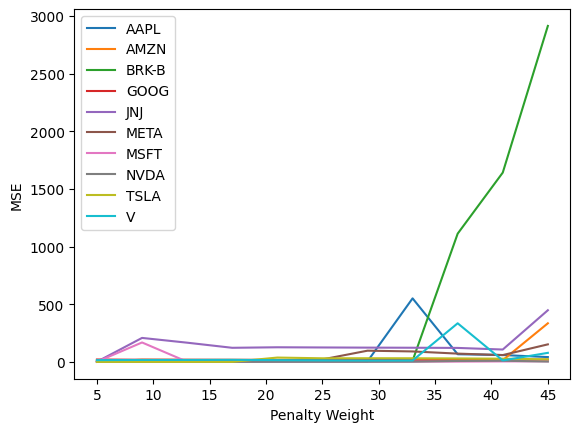

In [56]:
for j in stock_list:
        plt.plot(list(range(5,49,4)),stock_score[j],label = j)
plt.xlabel('Penalty Weight')
plt.ylabel('MSE')
plt.legend()
plt.show()

### We can find that when the amount of feature is smaller than 25, the MSE is smaller than later. So, I will retune the feature selection part to seek for the best features set for the training dataset

In [57]:
stock_score = dict()
for j in stock_list:
    freq = 'Daily'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    alpha_score = []

    for i in range(3,25,2):
        cv = 5
        scores = []
        tscv = TimeSeriesSplit(n_splits=cv)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            pipe = make_pipeline(MinMaxScaler(),Ridge(alpha=i))
            sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=i,scoring='neg_root_mean_squared_error')
            sfs.fit(X_train,y_train)
            X_train = sfs.transform(X_train)
            pipe.fit(X_train,y_train)
            X_test =  sfs.transform(X_test)
            y_pred = pipe.predict(X_test)
            scores.append(mean_squared_error(y_pred,y_test,squared=False))
        average_score = np.mean(scores)
        alpha_score.append(average_score)
    print(j,alpha_score)
    stock_score[j] = alpha_score

AAPL [4.833129196216866, 4.953479629742505, 5.302824447216525, 5.82662730670256, 5.913685234622035, 5.952592244342553, 5.637067614289418, 5.673827069544677, 5.723424338623984, 5.394769188294442, 5.437334905526136]
AMZN [0.8540189692056745, 0.8879350548314481, 0.9535194886342644, 20.032490320603344, 21.035380109936618, 18.31596347092796, 18.573813557941627, 18.482477211870176, 18.475594910063602, 18.411896196414666, 18.351878788479972]
BRK-B [10.935366164544153, 12.882101684820906, 12.752566247623859, 12.657974105922515, 11.514210365788633, 11.524445399031332, 11.652143328323056, 10.318933373960828, 10.517929082555435, 10.721722137877368, 10.962105414938918]
GOOG [1.1902112050225147, 21.6557005234595, 22.38025749707932, 19.486686035625702, 19.28451015158691, 19.32075260093024, 18.701537395557768, 18.527849576645117, 18.101761500144274, 17.411971398663127, 17.277147917175707]
JNJ [2.655732752535016, 2.437536442784208, 3.14818276541756, 208.8996347687545, 208.99665164660172, 167.584061801

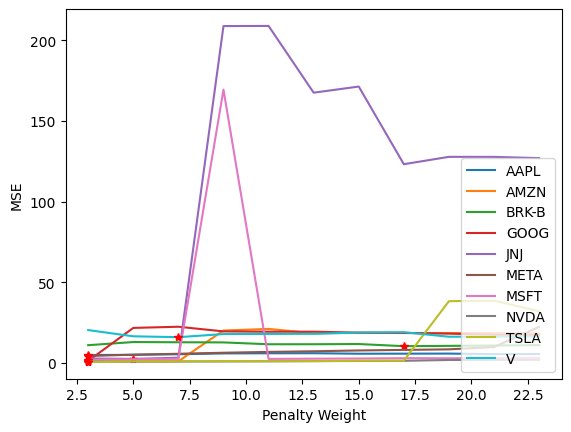

In [59]:
for j in stock_list:
    plt.plot(list(range(3,25,2)),stock_score[j],label = j)
    plt.plot(list(range(3,25,2))[stock_score[j].index(min(stock_score[j]))],min(stock_score[j]),'*r')
plt.xlabel('Penalty Weight')
plt.ylabel('MSE')
plt.legend(loc=4)
plt.show()

### Generally Speaking, We can find that 7 features could be an optimal selection for almost stock, except BRK-B. The stock named BRK-B need to have 17 features.

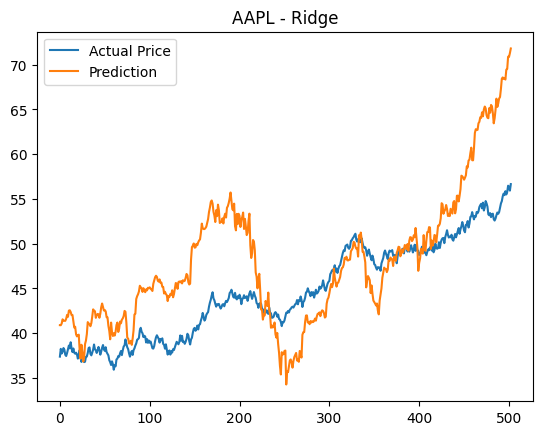

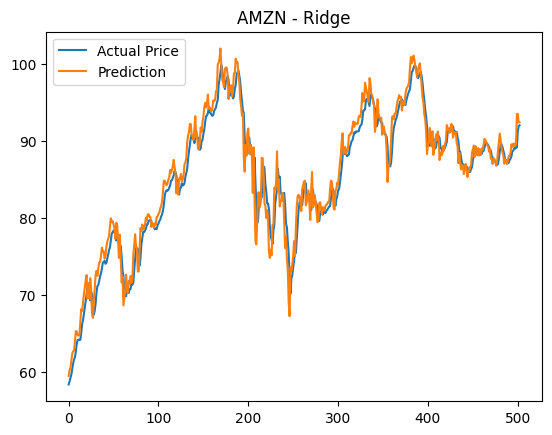

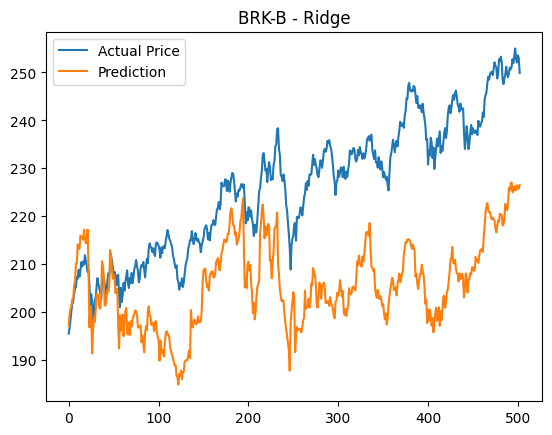

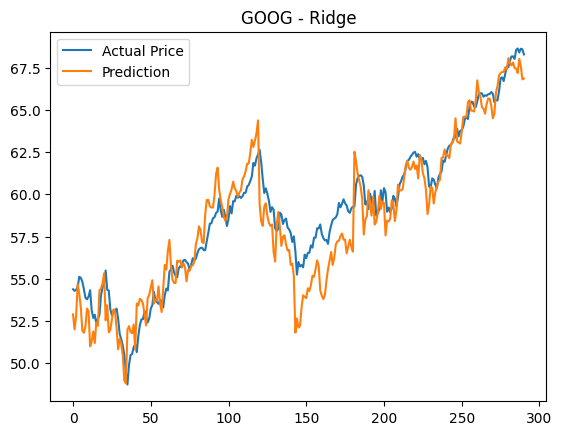

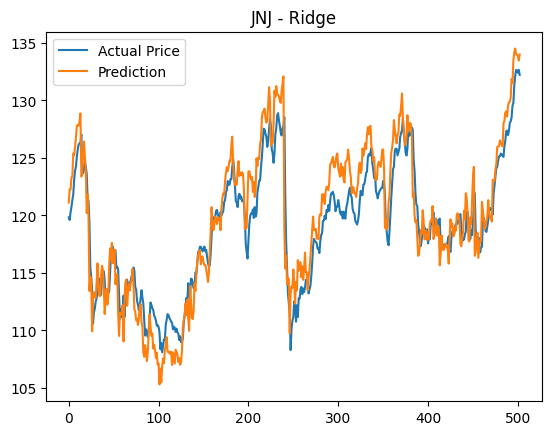

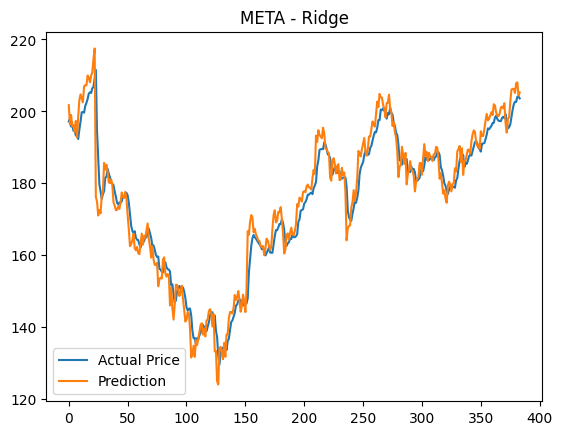

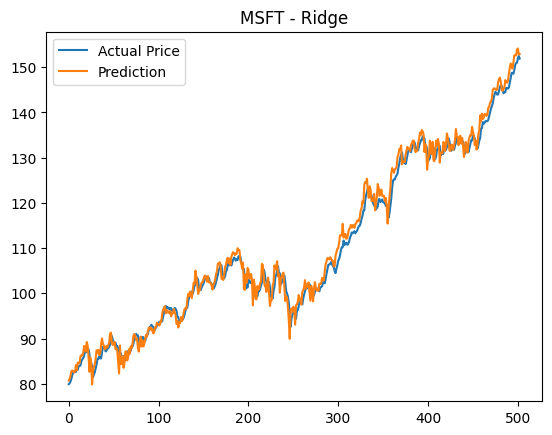

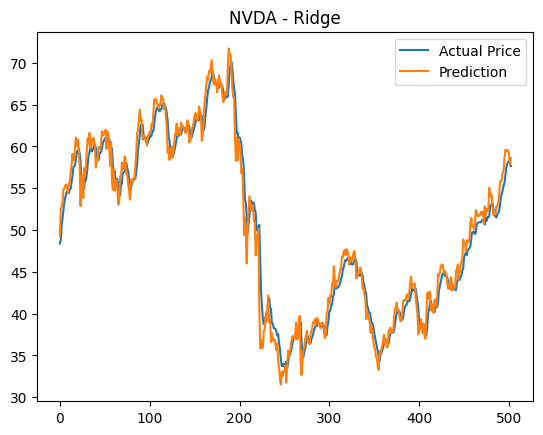

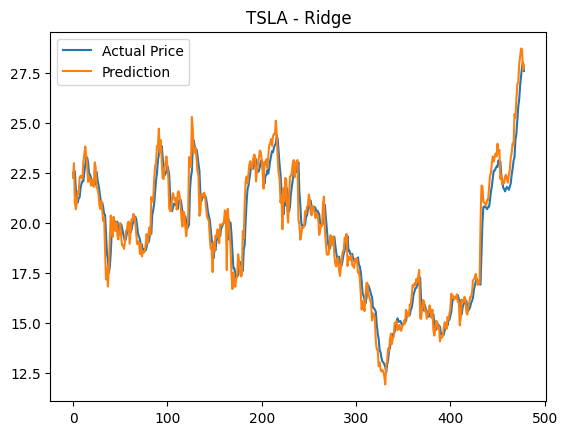

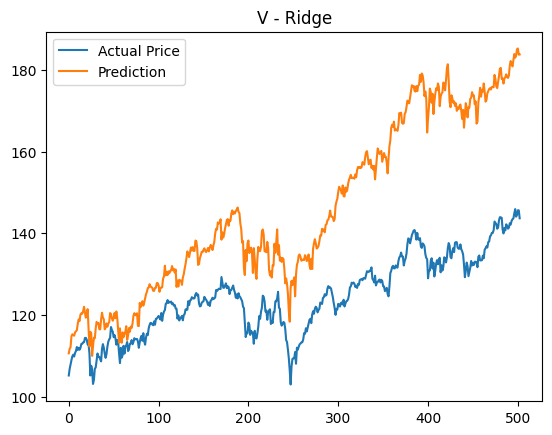

In [62]:
cv = 5
scores = dict()
selection_collect = dict()
for j in stock_list:
    freq = 'Daily'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    
    tscv = TimeSeriesSplit(n_splits=cv)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
    pipe = make_pipeline(MinMaxScaler(),Ridge(alpha=7))
    n = 7
    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=n,scoring='neg_root_mean_squared_error',cv=tscv)
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipe.fit(X_train,y_train)
    selection_collect[j] = predictors.columns.values[sfs.get_support()]
    X_test =  sfs.transform(X_test)
    y_pred = pipe.predict(X_test)
    plt.plot(range(0,len(y_pred)),y_pred,label = 'Actual Price')
    plt.plot(range(0,len(y_pred)),y_test,label = 'Prediction')
    plt.legend()
    plt.title(j + ' - Ridge')
    plt.show()
    scores[j] = mean_squared_error(y_pred,y_test,squared=False)

In [64]:
scores

{'AAPL': 5.944432893494602,
 'AMZN': 1.918134001278662,
 'BRK-B': 23.037445938378436,
 'GOOG': 1.4609646536386034,
 'JNJ': 2.2800724317295082,
 'META': 4.666096299044888,
 'MSFT': 1.9152884155509058,
 'NVDA': 1.7820171540626157,
 'TSLA': 0.7975562059319845,
 'V': 24.723440669993746}

In [65]:
selection_collect

{'AAPL': array(['dpr', 'cash_ratio', 'gdpr2', 'MFI', 'AD', 'MACD_Histo',
        'Pos_lag1'], dtype=object),
 'AMZN': array(['pay_turn', 'SMA', 'EMA', 'STOCH_k', 'STOCK_d', 'MACD_Histo',
        'Neu_lag2'], dtype=object),
 'BRK-B': array(['npm', 'fedfunds', 'EMA', 'AD', 'VWAP', 'SPY', 'NDAQ'],
       dtype=object),
 'GOOG': array(['npm', 'roa', 'curr_ratio', 'pay_turn', 'EMA', 'MACD_Histo', 'SPY'],
       dtype=object),
 'JNJ': array(['npm', 'capital_ratio', 'EMA', 'STOCH_k', 'STOCK_d', 'MACD_Histo',
        'NDAQ'], dtype=object),
 'META': array(['gpm', 'SMA', 'EMA', 'STOCH_k', 'STOCK_d', 'MACD_Histo',
        'Neu_lag2'], dtype=object),
 'MSFT': array(['SMA', 'EMA', 'STOCH_k', 'STOCK_d', 'AD', 'MACD_Histo', 'NDAQ'],
       dtype=object),
 'NVDA': array(['inv_turn', 'sale_nwc', 'SMA', 'EMA', 'STOCH_k', 'STOCK_d',
        'MACD_Histo'], dtype=object),
 'TSLA': array(['cash_ratio', 'rd_sale', 'SMA', 'EMA', 'STOCH_k', 'STOCK_d',
        'MACD_Histo'], dtype=object),
 'V': array(['dpr', 

## Feature Selection Statistics

In there, we want to investigate what features are the most important to be used within the ridge regression model. So, we count the frequency of each features to be selected.

In [66]:
features = pd.Series(data = np.zeros(len(predictors.columns)),index=predictors.columns)

for stock in stock_list:
    curr_feature = selection_collect[stock]
    for curr in curr_feature:
        features.loc[curr] += 1

In [67]:
tech_list = ['SMA','EMA','STOCH_k','STOCK_d','RSI','MFI','SAR','AD','MACD','MACD_Signal','MACD_Histo','VWAP','SPY','NDAQ']
funda_list = ['pcf','PEG_trailing','dpr','npm','gpm','roa','roe','capital_ratio','de_ratio','cash_ratio','curr_ratio','inv_turn','pay_turn','sale_nwc','rd_sale','accrual']
macro_list = ['gdpr1','gdpr2','cpi','bond20yr','bond30yr','fedfunds','cpir','wpir','unemp','employ']
nlp_list = ['Pos_lag2','Pos_lag3','Neg_lag1','Neg_lag2','Neg_lag3','Neu_lag1','Neu_lag2','Neu_lag3']

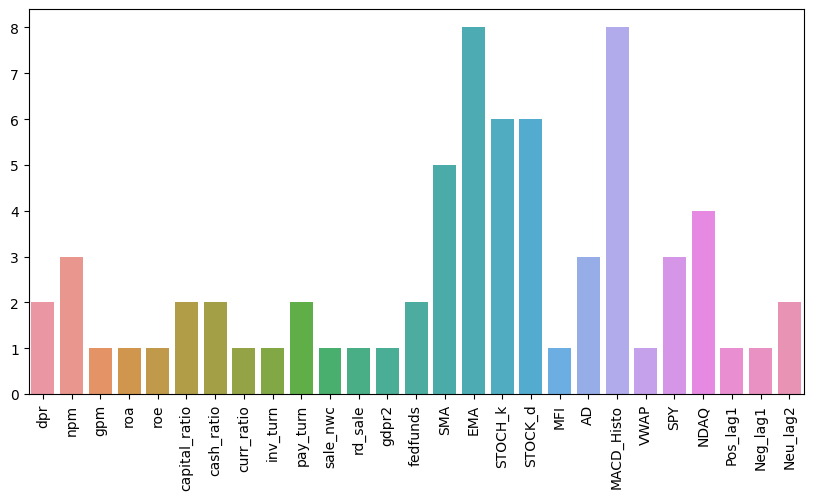

In [68]:
import seaborn as sns
usefeature = features[features!=0].index.values.tolist()
plt.figure(figsize=[10,5])
ax = sns.barplot(features[features!=0].to_frame().T)
ax.set_xticklabels(labels=usefeature,rotation=90)
plt.show()

According to the graph, we can find that tech predictors are pretty useful to predict the actual price of stocks. Then, it will come to the Marco predictors. Fundamental Indicators and NLP indicators are useful but only small amount of them.

## Weekly Frequency

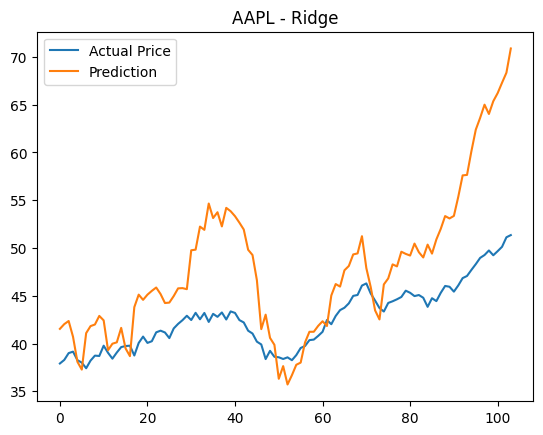

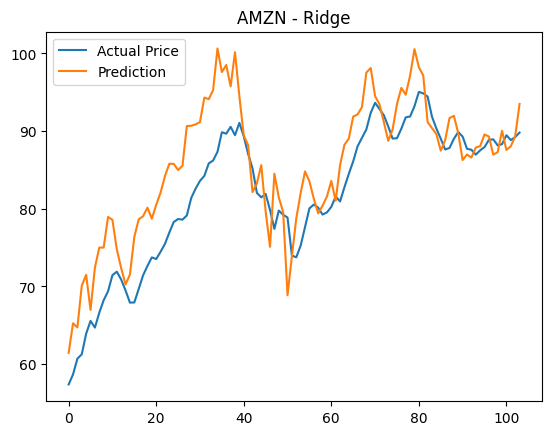

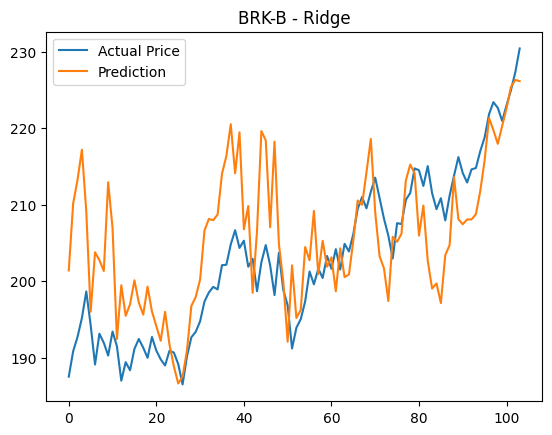

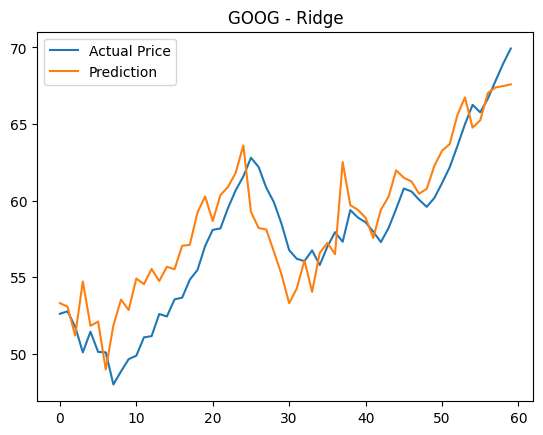

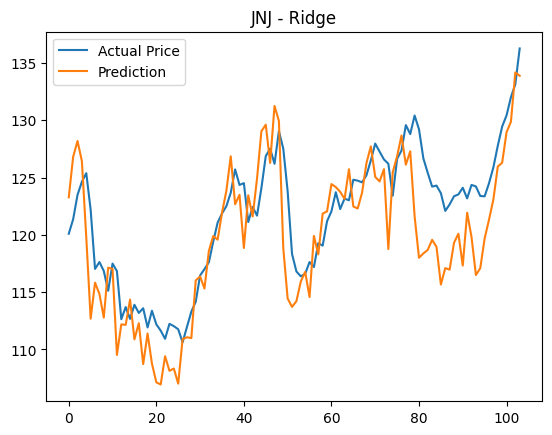

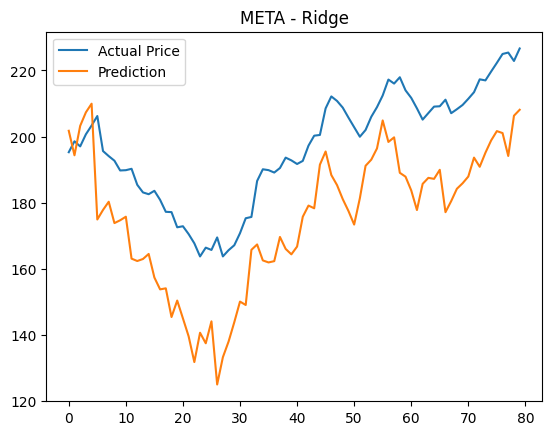

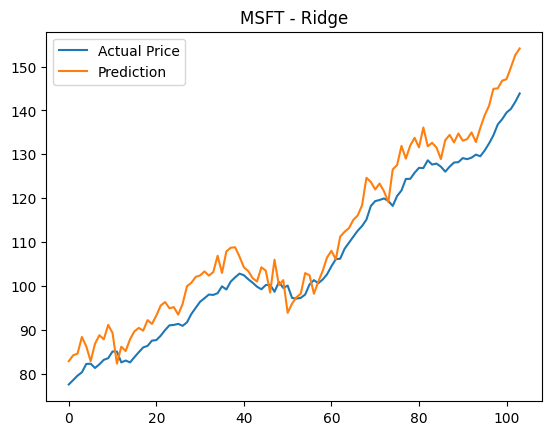

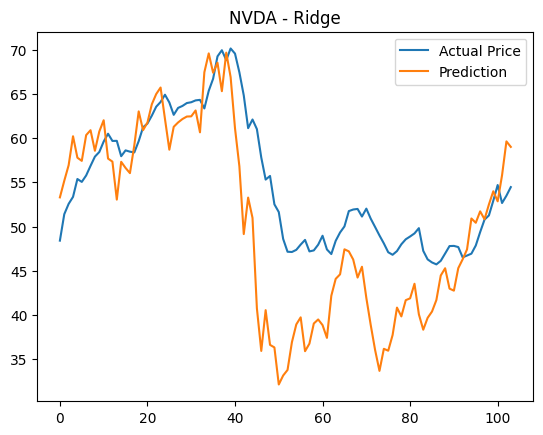

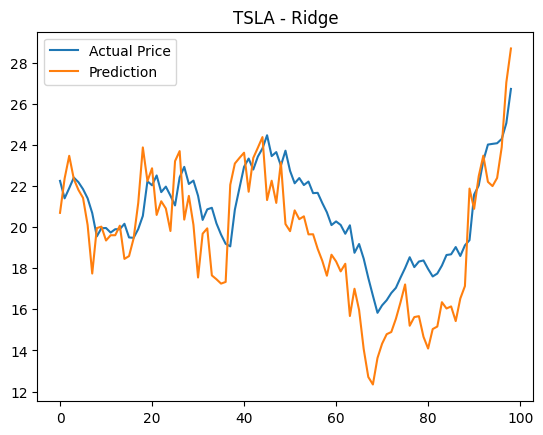

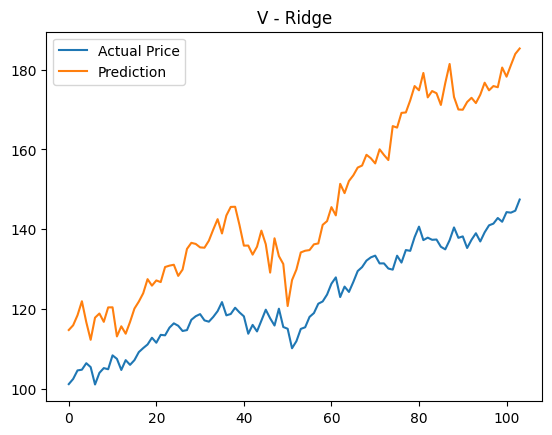

In [69]:
cv = 5
scores = dict()
selection_collect = dict()
for j in stock_list:
    freq = 'Weekly'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Weekly/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    
    tscv = TimeSeriesSplit(n_splits=cv)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
    pipe = make_pipeline(MinMaxScaler(),Ridge(alpha=7))
    n = 7
    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=n,scoring='neg_root_mean_squared_error',cv=tscv)
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipe.fit(X_train,y_train)
    selection_collect[j] = predictors.columns.values[sfs.get_support()]
    X_test =  sfs.transform(X_test)
    y_pred = pipe.predict(X_test)
    plt.plot(range(0,len(y_pred)),y_pred,label = 'Actual Price')
    plt.plot(range(0,len(y_pred)),y_test,label = 'Prediction')
    plt.legend()
    plt.title(j + ' - Ridge')
    plt.show()
    scores[j] = mean_squared_error(y_pred,y_test,squared=False)

In [70]:
scores

{'AAPL': 7.124349934129329,
 'AMZN': 5.497495639900085,
 'BRK-B': 8.381214009615762,
 'GOOG': 2.4526999646232768,
 'JNJ': 3.99726628663955,
 'META': 23.17891573593356,
 'MSFT': 5.633750144364796,
 'NVDA': 7.768553098518735,
 'TSLA': 2.1606877761518564,
 'V': 25.074903152327625}

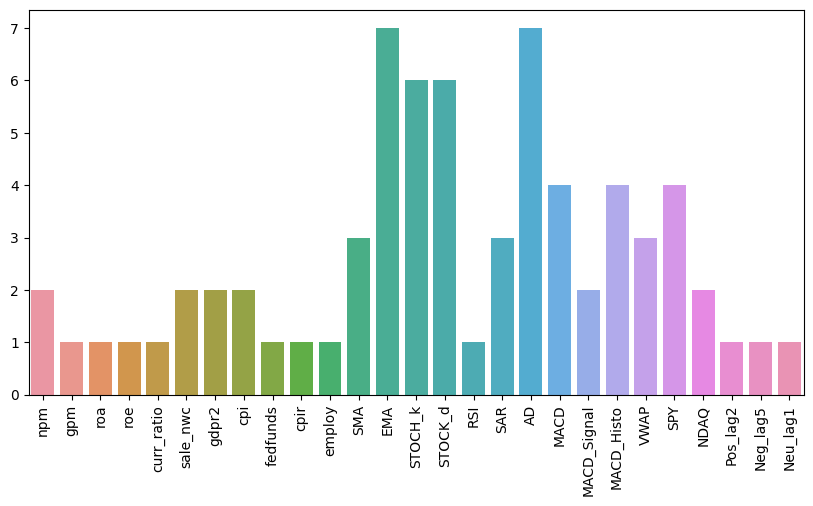

In [71]:
features = pd.Series(data = np.zeros(len(predictors.columns)),index=predictors.columns)

for stock in stock_list:
    curr_feature = selection_collect[stock]
    for curr in curr_feature:
        features.loc[curr] += 1
        
usefeature = features[features!=0].index.values.tolist()
plt.figure(figsize=[10,5])
ax = sns.barplot(features[features!=0].to_frame().T)
ax.set_xticklabels(labels=usefeature,rotation=90)
plt.show()

### Monthly Frequency

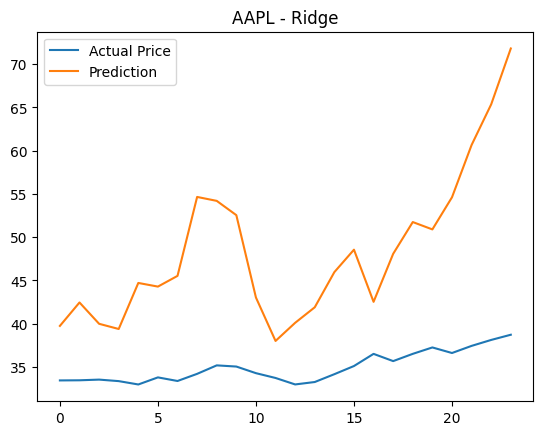

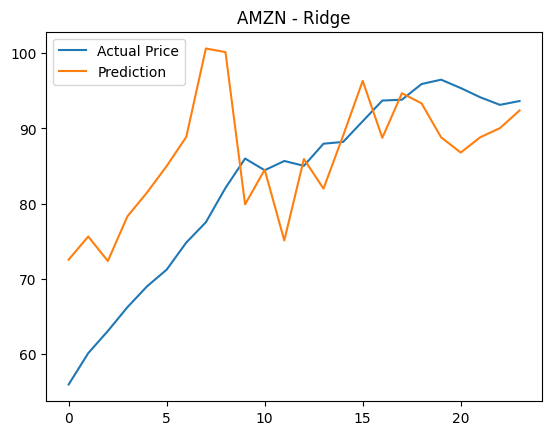

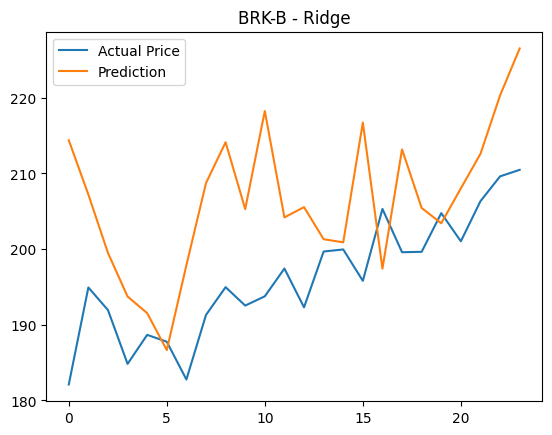

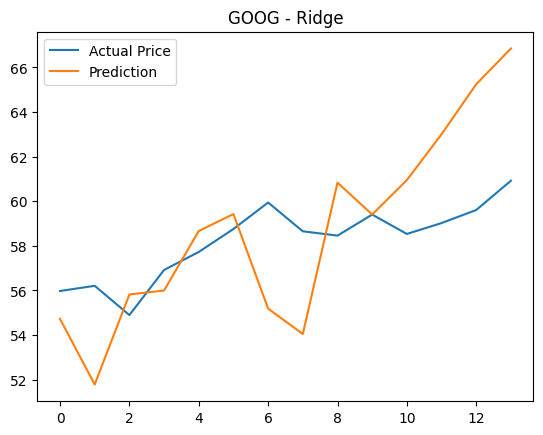

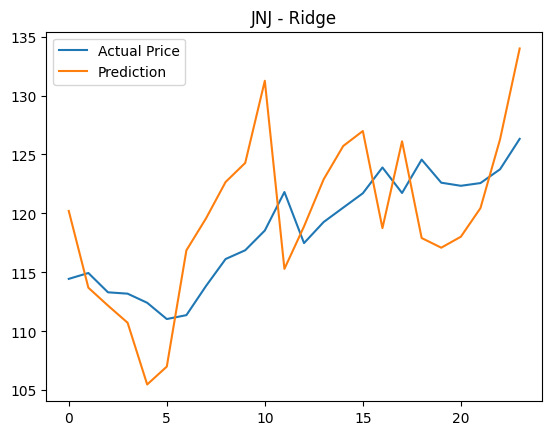

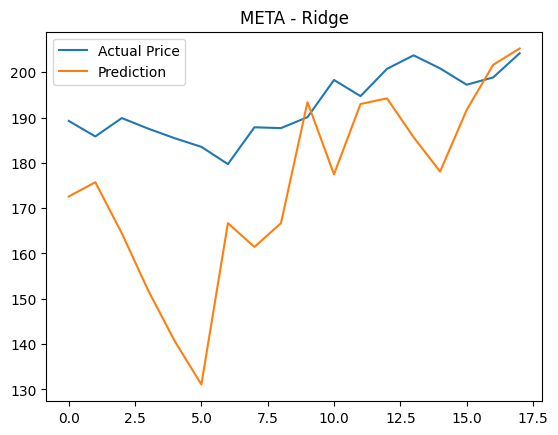

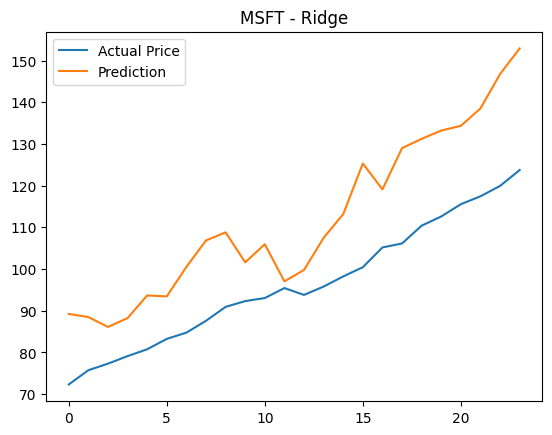

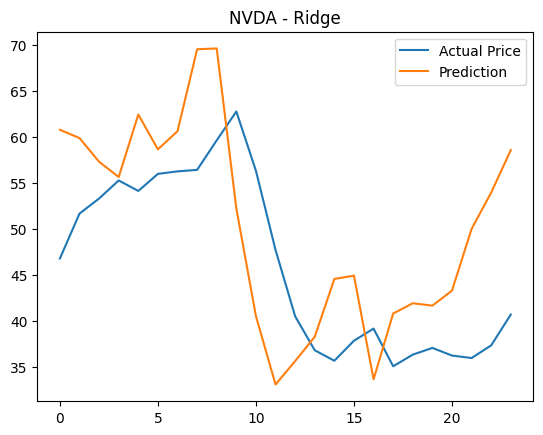

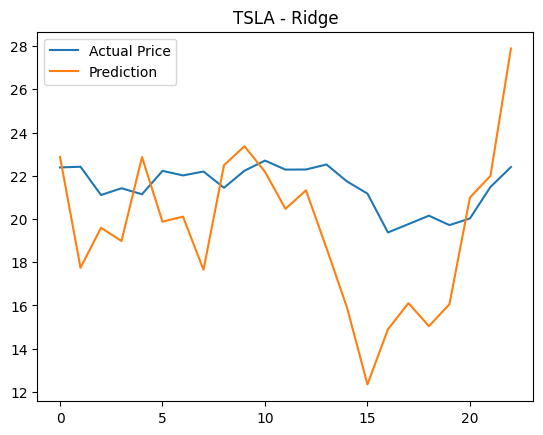

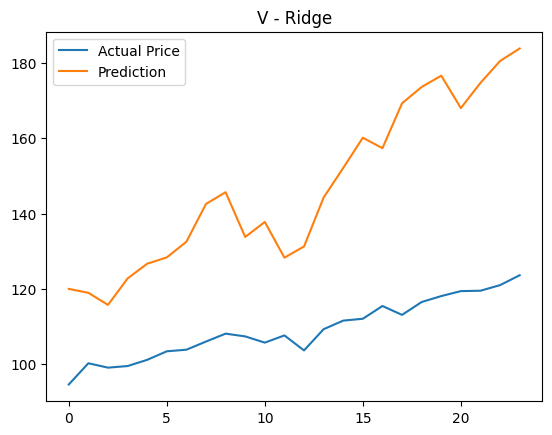

In [72]:
cv = 5
scores = dict()
selection_collect = dict()
for j in stock_list:
    freq = 'Monthly'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    
    tscv = TimeSeriesSplit(n_splits=cv)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
    pipe = make_pipeline(MinMaxScaler(),Ridge(alpha=7))
    n = 7
    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=n,scoring='neg_root_mean_squared_error',cv=tscv)
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipe.fit(X_train,y_train)
    selection_collect[j] = predictors.columns.values[sfs.get_support()]
    X_test =  sfs.transform(X_test)
    y_pred = pipe.predict(X_test)
    plt.plot(range(0,len(y_pred)),y_pred,label = 'Actual Price')
    plt.plot(range(0,len(y_pred)),y_test,label = 'Prediction')
    plt.legend()
    plt.title(j + ' - Ridge')
    plt.show()
    scores[j] = mean_squared_error(y_pred,y_test,squared=False)

In [73]:
scores

{'AAPL': 15.178012051888075,
 'AMZN': 10.349865319003127,
 'BRK-B': 13.54113605599337,
 'GOOG': 3.406241836032549,
 'JNJ': 5.588749335783379,
 'META': 23.271893083624136,
 'MSFT': 17.121649010235462,
 'NVDA': 9.862835644328339,
 'TSLA': 3.618311620438881,
 'V': 40.27594052387919}

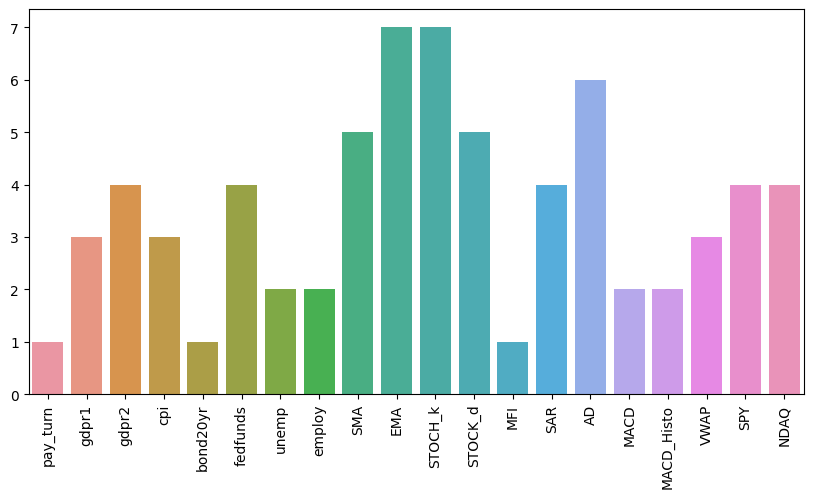

In [74]:
features = pd.Series(data = np.zeros(len(predictors.columns)),index=predictors.columns)

for stock in stock_list:
    curr_feature = selection_collect[stock]
    for curr in curr_feature:
        features.loc[curr] += 1
        
usefeature = features[features!=0].index.values.tolist()
plt.figure(figsize=[10,5])
ax = sns.barplot(features[features!=0].to_frame().T)
ax.set_xticklabels(labels=usefeature,rotation=90)
plt.show()

# Conclusion

According to what we have done, we can make the following conclusion:
- Daily Frequency has the best prediction result. As the frequency to be lower, the prediction will become worse. It is reasonable, because of the data quality and large change gap can not be captured through the dataset.


- For all the features, Technical indicators has the strongest prediction powers. Because according to all the frequencies, almost all the tech indicators have been selected out. Then, several fundamental indicators and macro indicators are selected out based on the result.